If not done: !pip install pm4py

In [1]:
%load_ext autoreload
%autoreload 1
%matplotlib inline
import matplotlib.pyplot as plt
from pm4py.objects.log.importer.xes import factory as importer
from matplotlib import collections as mc
from matplotlib import cm
import pandas as pd
import time
%aimport BEP_PM

In [4]:
#log = importer.apply('Road_Traffic_Fine_Management_Process.xes')
rf = BEP_PM.EventLog('roadfines', 'concept:name', 'time:timestamp', resource_id='org:resource')
#rf.clean_timezone()
#rf.save()

In [5]:
# # Reloading an already saved log named 'roadfines':
# rf = EventLog('roadfines', 'concept:name', 'time:timestamp')

In [6]:
rf.count_trace_types()

{('Create Fine', 'Send for Credit Collection'): 1}

In [7]:
# Manual reordering to match paper's segment order:
segments = rf.filter_segments()
segments[-1], segments[-2] = segments[-2], segments[-1] 
segments.insert(0, segments.pop(-1))
segments[-1], segments[-2] = segments[-2], segments[-1] 

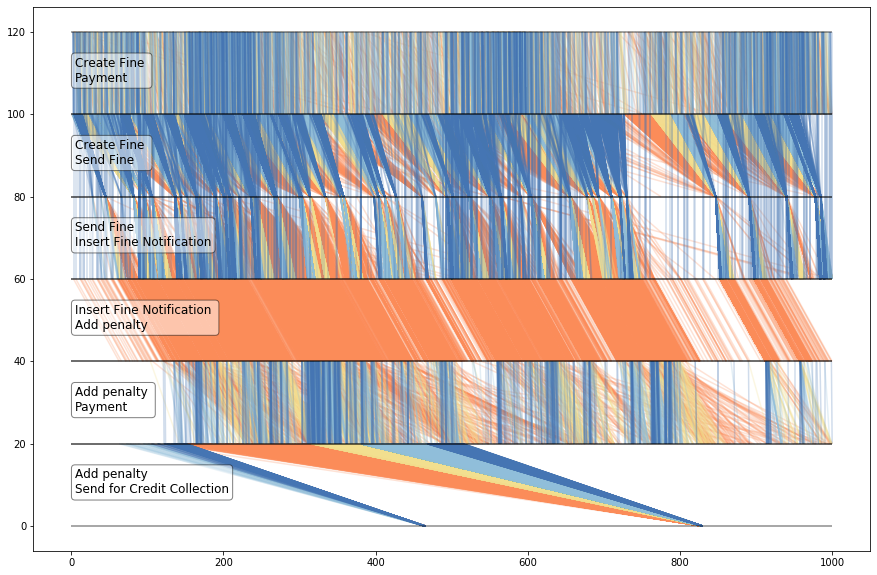

In [8]:
class_colors = [(69/256, 117/256, 180/256), (145/256, 191/256, 219/256), (243/256, 224/256, 144/256),
                (252/256, 141/256, 89/256)]

rf.performance_spectrum(segments, x_max=int(1500), metric='duration', classifier=rf.classify_duration_hist, args=[4])
fig, ax = plt.subplots(figsize=[15,10])
rf.plot_performance_spectrum(class_colors, ax, mask=(rf.pf['end_time'] <= 1000))

In [10]:
rf.performance_spectrum(segments, x_max=int(1500), metric=['start_time', 'end_time'], classifier=rf.batch_classifier, args=[10,0])

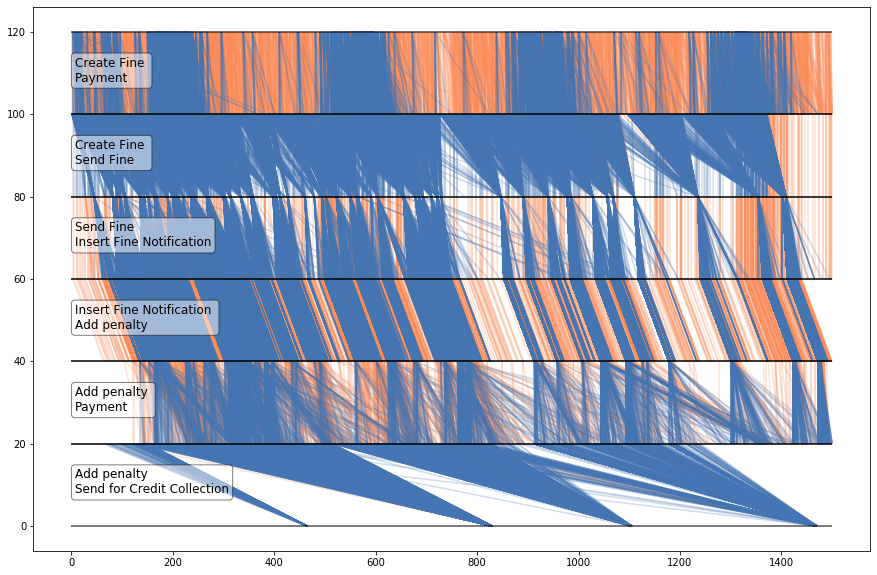

In [15]:
class_colors = [(252/256, 141/256, 89/256),
                (69/256, 117/256, 180/256)]
fig, ax = plt.subplots(figsize=[15,10])
rf.plot_performance_spectrum(class_colors, ax, order='reversed', alpha=.4)

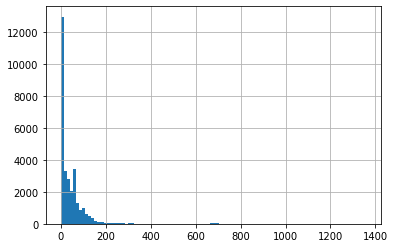

In [261]:
rf.pf[rf.pf["class"]==1]['duration'].hist(bins= 100)

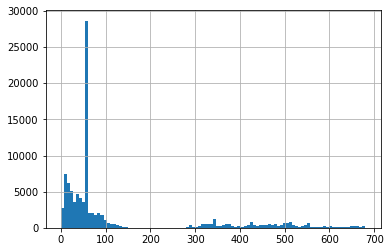

In [262]:
rf.pf[rf.pf["class"]==0]['duration'].hist(bins= 100)